Before we begin, we will change a few settings to make the notebook look a bit prettier

In [1]:
%%html
<style> body {font-family: "Calibri", cursive, sans-serif;} </style>

<img src="https://iknl.nl/images/default-source/images/.png?sfvrsn=3" align="right">

# Using VERTIGO (locally)
In this notebook, we simulate a distributed scenario where use VERTIGO. Namely, we perform a LR analysis in a dataset in a centralized way and in a (simulated) distributed way. Then, we compare the resulting coefficients of both approaches. 

For a step-by-step explanation of how VERTIGO works, see the notebook [`demo_vertigo`](https://nbviewer.jupyter.org/github/IKNL/vertigo/blob/master/scripts/demo_vertigo.ipynb). For a real-life distributed implementation of VERTIGO using our [privacy preserving DL infrastructure](https://github.com/IKNL/ppDLI), see our repository, `d_vertigo`.

All right. Let's get started.

## Preliminaries
Display plots.

In [2]:
%matplotlib inline

Import packages

In [3]:
import os
import copy
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import binarize

Import user-defined local modules.

In [4]:
import vertigo as v
import auxiliaries

Set (default) plotting parameters.

In [5]:
mpl.rcParams['font.sans-serif'] = "Calibri"
mpl.rcParams['font.family'] = "sans-serif"
sns.set(font_scale=1.75)
sns.set_style('ticks')
plt.rc('axes.spines', top=False, right=False)

Setup paths.

In [6]:
# Setup working path
os.chdir(os.getcwd())

PATH_DATA = pathlib.Path(r'../data/')
PATH_RESULTS = pathlib.Path(r'../results/')

if not PATH_DATA.exists():
    raise ValueError("Data directory not found.")
    
if not PATH_RESULTS.exists():
    path_results.mkdir()

Setup execution parameters.

In [7]:
# Test/train partitioning.
TEST_PROP = 0.2
SEED = 31416 # For reproducibility.

# Centralized/VERTIGO regression.
LAMBDAS_ = np.array([0.1, 1, 5, 10, 20, 50, 100, 200, 500, 1000])
N_LAMBDAS = len(LAMBDAS_)
TOLERANCE = 1e-8
THRESHOLDS = np.array([0.5])
N_THRESHOLDS = len(THRESHOLDS)

## The data
We will be using the [Breast Cancer Wisconsin Diagnostic Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29). The data consists of real-valued features computed from a digitalized image of breast biposy. The features describe the characteristics of the cell nuclei present in the image: 
* `radius` - mean of distances from center to points on the perimeter
* `texture` - standard deviation of gray-scale values
* `perimeter`
* `area`
* `smoothness` - local variation in radii lengths
* `compactness` - perimeter^2 / area - 1.0
* `concavity` - severity of concave portions of the contour
* `concave points` - number of concave portions of the contour
* `symmetry`
* `fractal dimension` - "coastline approximation" - 1

The mean, standard error, and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For the sake of simplicity, we will only consider the mean values of the features, resulting in 10 features. The output variable is `diagnosis`, which states if result of the biopsy was a benign (`B`) or a malignant (`M`) tumor.

In [8]:
df = pd.read_csv(PATH_DATA/'data.csv', index_col=0, usecols=range(0, 12))
df.head(5)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
id,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


Notice how in this case, all variables are continuous. If the data had categorical values, they would need to be encoded, preferably using [one-hot encoding](https://en.wikipedia.org/wiki/One-hot).

## Data pre-processing
Extract the features only

In [9]:
column_names = list(df.columns)[1:]
X_centralized = df[column_names]

In order to avoid having features that are dominant just because of their range, we will normalize them.

In [10]:
X_centralized = (X_centralized - np.min(X_centralized))/(np.max(X_centralized) - np.min(X_centralized))

### Re-structuring of the data
For the sake of this example, we will simulate two different parties. Each of these parties will have half of the features.

In [11]:
X1 = X_centralized[column_names[0:round(len(column_names)/2)]]
X1.head(5)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean
id,,,,,
842302,0.521037,0.022658,0.545989,0.363733,0.593753
842517,0.643144,0.272574,0.615783,0.501591,0.289880
84300903,0.601496,0.390260,0.595743,0.449417,0.514309
84348301,0.210090,0.360839,0.233501,0.102906,0.811321
84358402,0.629893,0.156578,0.630986,0.489290,0.430351


In [12]:
X2 = X_centralized[column_names[round(len(column_names)/2):]]
X2.head(5)

,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
id,,,,,
842302,0.792037,0.703140,0.731113,0.686364,0.605518
842517,0.181768,0.203608,0.348757,0.379798,0.141323
84300903,0.431017,0.462512,0.635686,0.509596,0.211247
84348301,0.811361,0.565604,0.522863,0.776263,1.000000
84358402,0.347893,0.463918,0.518390,0.378283,0.186816


### Output

In [13]:
y = df[['diagnosis']]

Centralized LR uses an output of 0 or 1...

In [14]:
y_centralized = y['diagnosis'].map(lambda x: 1 if x=='M' else 0)
y_centralized = pd.DataFrame(y_centralized)

...while VERTIGO uses an output of -1 or 1.

In [15]:
y_vertigo = y['diagnosis'].map(lambda x: 1 if x=='M' else -1)
y_vertigo = pd.DataFrame(y_vertigo)

## Class balancing
This is particularly important for a logistic regression. If a class is underrepresented, the model will apparently perform well, but it will likely just predict one class all the time. Thus we need to balance it. We will do so using downsampling.

In [16]:
X_centralized_balanced, y_centralized_balanced = auxiliaries.downsample(X_centralized, y_centralized, random_state=0)
X1_balanced, y_vertigo_balanced = auxiliaries.downsample(X1, y_vertigo, random_state=0)
X2_balanced, _ = auxiliaries.downsample(X2, y_vertigo, random_state=0)

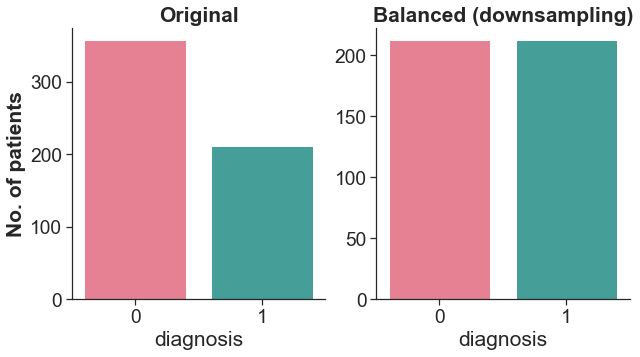

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 5])
sns.countplot(x='diagnosis', data=y_centralized, palette='husl', ax=ax1)
sns.countplot(x='diagnosis', data=y_centralized_balanced, palette='husl', ax=ax2)
ax1.set_title("Original", weight='bold')
ax2.set_title("Balanced (downsampling)", weight='bold')
ax1.set_ylabel("No. of patients", weight='bold')
ax2.set_ylabel("")
fig.savefig(PATH_RESULTS/('class_proportion.pdf'), dpi=1000, bbox_inches='tight')
plt.show();

## Data partition
Partition data into training and testing sets.

In [18]:
X_centralized_train, X_centralized_test, y_centralized_train, y_centralized_test = train_test_split(X_centralized_balanced, y_centralized_balanced, test_size=TEST_PROP, random_state=SEED)

X1_train, X1_test, y_vertigo_train, y_vertigo_test = train_test_split(X1_balanced, y_vertigo_balanced, test_size=TEST_PROP, random_state=SEED)
X2_train, X2_test, _, _ = train_test_split(X2_balanced, y_vertigo_balanced, test_size=TEST_PROP, random_state=SEED)

X_vertigo_train = list([X1_train, X2_train])
Z_vertigo_test = list([X1_test, X2_test])

## Perform regressions
We will obtain the models' coefficients, compute their probabilities, and generate their predictions.

First, we need to initialize some variables

In [19]:
n_coefficients = len(column_names) + 1 # +1 for the intercept
centralized_coefficients = np.zeros([N_LAMBDAS, n_coefficients])
vertigo_coefficients = np.zeros([N_LAMBDAS, n_coefficients])

n_patients_test = len(X_centralized_test)

accuracies_logistic = np.zeros([N_LAMBDAS, N_THRESHOLDS])
accuracies_vertigo = np.zeros([N_LAMBDAS, N_THRESHOLDS])
prediction_matches = np.zeros([N_LAMBDAS, N_THRESHOLDS])

y_centralized_prob = np.zeros([N_LAMBDAS, 1, n_patients_test])
y_vertigo_prob = np.zeros([N_LAMBDAS, 1, n_patients_test])
y_centralized_pred = np.zeros([N_LAMBDAS, N_THRESHOLDS, n_patients_test])
y_vertigo_pred = np.zeros([N_LAMBDAS, N_THRESHOLDS, n_patients_test])

Then, we will perform the regressions, parametrizing them with different $\lambda$ values.

In the centralized case, we will use sci-kit's [`liblinear`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), since it is the most appropriate one to compare with VERTIGO: it allows L2 regularization (penalization) with a dual formulation.

For the VERTIGO case, we are using an object `v.vertigo`, which actually does the processing and heavy-lifting. If you are intersted in the details, you can check it out, as well as the accompanying notebook [`demo_vertigo`](https://nbviewer.jupyter.org/github/IKNL/vertigo/blob/master/scripts/demo_vertigo.ipynb).

In [20]:
for ii, LAMBDA_ in enumerate(LAMBDAS_):
    
    # Create regression objects and fit data.
    centralized_regression = LogisticRegression(solver='liblinear', C=1/LAMBDA_, intercept_scaling=1, penalty='l2', dual=True, tol=TOLERANCE, verbose=False);
    _ = centralized_regression.fit(X_centralized_train, y_centralized_train.values.ravel())
    
    vertigo = v.vertigo(lambda_=LAMBDA_, tol=TOLERANCE, verbose=False)
    _ = vertigo.fit(X_vertigo_train, y_vertigo_train)

    # Store the coefficients.
    centralized_coefficients[ii, 0:-1] = centralized_regression.coef_[0]
    centralized_coefficients[ii, -1] = centralized_regression.intercept_
    vertigo_coefficients[ii, 0:-1] = vertigo.beta_coef_
    vertigo_coefficients[ii, -1] = vertigo.intercept_
    
    
    # Compute probabilities
    y_centralized_prob[ii, 0, :] = centralized_regression.predict_proba(X_centralized_test)[:, 1]
    
    centralized_regression_vertigo = copy.deepcopy(centralized_regression)
    centralized_regression_vertigo.coef_ = np.array([vertigo.beta_coef_])
    centralized_regression_vertigo.intercept_ = np.array([vertigo.intercept_])
    y_vertigo_prob[ii, 0, :] = centralized_regression_vertigo.predict_proba(X_centralized_test)[:, 1]
    
    # Generate predictions.
    for jj, THRESHOLD in enumerate(THRESHOLDS):
        y_centralized_pred[ii, jj, :] = binarize(y_centralized_prob[ii, 0, :].reshape(-1, 1), THRESHOLD).ravel()
        y_vertigo_pred[ii, jj, :] = binarize(y_vertigo_prob[ii, 0, :].reshape(-1, 1), THRESHOLD).ravel()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Analyzing the coefficients
Let's take a look at how similar or how different are the centralized and the VERTIGO coefficients.

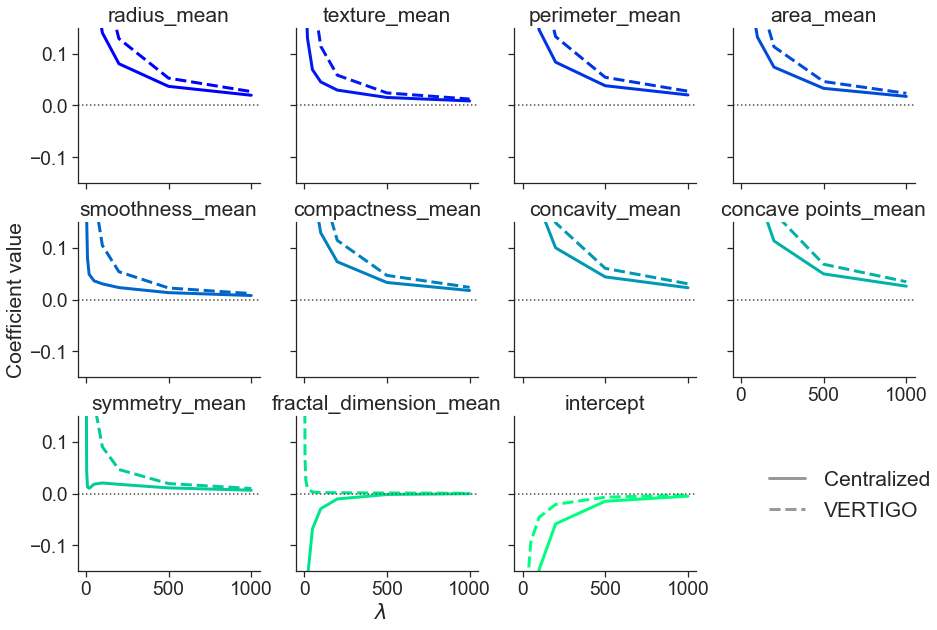

In [21]:
# Initialize some variables.
features = column_names.copy()
features.append('intercept')
n_features = len(features)

fig, axes = plt.subplots(3, 4, figsize=[15, 10])
fig.subplots_adjust(hspace=0.25)
colors = [plt.cm.winter(ii) for ii in np.linspace(0, 1, n_features)]

# Create coefficient subplots.
n_plot = 0
for ax, centralized_coeff, vertigo_coeff, feature in zip(axes.ravel(), centralized_coefficients.T, vertigo_coefficients.T, features):
    n_plot += 1

    ax.plot(LAMBDAS_, centralized_coeff, linewidth=3, color=colors[n_plot-1]);
    ax.plot(LAMBDAS_, vertigo_coeff, linewidth=3, linestyle='--', color=colors[n_plot-1]);
    ax.axhline(y=0, xmin=0, xmax=max(LAMBDAS_), linestyle=':', color=[0.3, 0.3, 0.3]);
    
    ax.set_ylim([-0.15, 0.15])
    ax.set_title(feature)
    
    if not n_plot in [8, 9, 10, 11]:
        ax.xaxis.set_ticklabels([])
    if not n_plot in [1, 5, 9]:
        ax.yaxis.set_ticklabels([])
    if n_plot == 10:
        ax.set_xlabel(r"$\lambda$", horizontalalignment='right')
    if n_plot == 5:
        ax.set_ylabel("Coefficient value")    

# Create legend subplot.
ax_last = axes.ravel()[-1]
ax_last.axhline(y=0.6, xmin=0.2, xmax=0.4, linewidth=3, color=[0.6, 0.6, 0.6])
ax_last.axhline(y=0.4, xmin=0.2, xmax=0.4, linewidth=3, linestyle='--', color=[0.6, 0.6, 0.6])
ax_last.text(0.5, 0.55, 'Centralized')
ax_last.text(0.5, 0.35, 'VERTIGO')
ax_last.set_xlim([0, 1])
ax_last.set_ylim([0, 1])
ax_last.xaxis.set_visible(False)
ax_last.yaxis.set_visible(False)
ax_last.spines['left'].set_visible(False)
ax_last.spines['bottom'].set_visible(False)

fig.savefig(PATH_RESULTS/('coefficients.pdf'), dpi=1000, bbox_inches='tight')
plt.show();

The natural question now is: how do I define which parameters should my model use? Namely, we are talking about the threshold and $\lambda$ values. That's a good question and I'm afraid there's no easy answer for it.

For instance, the default threshold value of 0.5 might not be optimal for your application. In the case of $\lambda$ it is even more complicated. In the original paper, the authors used values of 80, 1000, and 1300 for their real-life examples. Unfortunately, they don't provide an explanation for their choice.

In the end, the optimal values for these parameters will depend on your data. Therefore, we recommend playing around with them until you find the best combination. Be sure that you optimize them using your training (and not your test) dataset!